In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('C:/Users/nerpa/Dropbox (Princeton)/Research/discrete_sr/code/SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [5]:
from commons.sparse_reg_bf import *
from identify_models import *
import copy

libs = srd.libs

# for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
scaler0 = Scaler(sub_inds=None, char_sizes=libs[0].col_weights, row_norms=None)
init0 = Initializer(method='combinatorial', start_k=2)
#init0 = Initializer(method='power', start_k=10)
#res0 = Residual(residual_type='fixed_column', anchor_col=0)
res0 = Residual(residual_type='dominant_balance')

iter0 = ModelIterator(max_k=10, backward_forward=True, brute_force=True) # test also boolean toggles
thres0 = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)
#thres0 = Threshold(threshold_type='information', ic=AIC)
#thres0 = Threshold(threshold_type='jump', gamma=1.5, n_terms=3)

opts = {'scaler': scaler0, 'initializer': init0, 'residual': res0,
        'model_iterator': iter0, 'threshold': thres0}
opts['verbose'] = False
opts1 = copy.deepcopy(opts) # need to be careful to deep copy for the stateful ModelIterator
opts['inhomog'] = False
opts['inhomog_col'] = None
#opts['verbose'] = False
sub_inds1 = list(range(len(libs[1].terms)))
#sub_inds1.remove(35) # dt rho[v_i * v_j * v_j]
#sub_inds1.remove(21) # rho * dt rho[v_i]
opts1['scaler'] = Scaler(sub_inds=sub_inds1, char_sizes=libs[1].col_weights)
opts1['residual'] = Residual(residual_type='fixed_column', anchor_col=13)
opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)

#opts1['verbose'] = True
opts1['inhomog'] = True
opts1['inhomog_col'] = 13 
    
opts['verbose']=False
opts1['verbose']=False

# note that interleave_identify doesn't work with inhomog or fixed-column residual
opts1['inhomog'] = False
opts1['inhomog_col'] = None
opts1['residual'] = copy.deepcopy(opts['residual'])
opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)

eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2, experimental=True)

[0.10 s]
Identified model: 0.9999999999338456 * dj rho[v_j] + 1.0 * dt rho = 0 (order 3, residual 7.88e-10)
[0.34 s]
Identified model: 1.0 * dj rho[v_i * v_j] + 0.9999999999820364 * dt rho[v_i] = 0 (order 4, residual 5.12e-10)


In [6]:
opts1['inhomog'] = True
opts1['inhomog_col'] = 13 # dt rho[v_i]

remove_terms = [21, 35] # rho * dt rho[v_i], dt rho[v_i * v_j * v_j]
for term in remove_terms:
    if term in opts1['scaler'].sub_inds:
        opts1['scaler'].sub_inds.remove(term) 
opts1['scaler'].reset_inds(opts1['scaler'].sub_inds)

opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=4)
opts1['verbose'] = False
Xi, lambd, best_term, lambda1 = sparse_reg_bf(libs[1].Q, **opts1)
zipped = [(libs[1].terms[i], c) for i, c in enumerate(Xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])
print(eqn, "; residual:", lambd)

-0.016958754913634695 * di rho + 1.0 * di rho[v_j * v_j] + 0.2791592729591624 * dt^2 di rho + 0.5934340149577384 * dt^2 rho[v_i] = 0 ; residual: 0.463469825336406


1.0 * dj rho[v_i * v_j] + 0.9999999999990757 * dt rho[v_i] = 0
rho


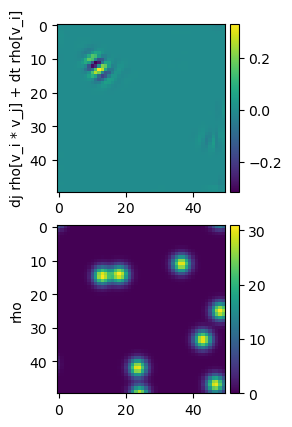

In [7]:
### plot strong-form fields

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

zero_arr = [0] * srd.n_dimensions
constant_weight = Weight(m=zero_arr, q=zero_arr, k=zero_arr) # should evaluate to 1 everywhere

def make_residual_arr(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs)[..., 0]

domain = srd.domains[0]
kc = 0 # can select x, y components

### residual plotting
equation = eqs[1]
print(equation)
ra = make_residual_arr(equation, domain, kc)

fig, (ax1, ax2) = plt.subplots(2, 1)
im = ax1.imshow(ra[:, :, 0])
#colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

### term plotting
#term = equation.term_list[0]
term = srd.libs[0].terms[1]
print(term)
kc = None
tw_arr = srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False)

im = ax2.imshow(tw_arr[:, :, 0])
#colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax2)

ax1.set_ylabel("dj rho[v_i * v_j] + dt rho[v_i]")
ax2.set_ylabel(str(term))

plt.show()

frame=0
frame=0
frame=0


MovieWriter stderr:
[out#0/mp3 @ 000001cbfa78e8c0] Output file does not contain any stream



CalledProcessError: Command '['C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '24', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'libx264', '-y', 'viz_test2.mp3']' returned non-zero exit status 1.

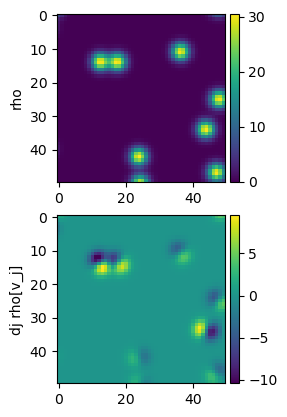

In [9]:
### plot strong-form fields

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viz_test2.mp3'

zero_arr = [0] * srd.n_dimensions
constant_weight = Weight(m=zero_arr, q=zero_arr, k=zero_arr) # should evaluate to 1 everywhere

def make_residual_arr(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs)[..., 0]

domain = srd.domains[0]
kc = None # can select x, y components

term1 = srd.libs[0].terms[find_term(libs[0].terms, 'rho')]
tw_arr = srd.make_tw_arr(term1, constant_weight, [domain], kc, by_parts=False)[..., 0]
fig, (ax1, ax2) = plt.subplots(2, 1)
im1 = ax1.imshow(tw_arr[:, :, 0])
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)

term2 = srd.libs[0].terms[find_term(libs[0].terms, 'dj rho[v_j]')]
tw_arr2 = srd.make_tw_arr(term2, constant_weight, [domain], kc, by_parts=False)[..., 0]
im2 = ax2.imshow(tw_arr2[:, :, 0])
#colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cb2 = plt.colorbar(im2, cax=cax2)

ax1.set_ylabel(str(term1))
ax2.set_ylabel(str(term2))

def animate(i):
    if i % 10 == 0:
        print(f"frame={i}")
    im1.set_array(tw_arr[:, :, i])
    im2.set_array(tw_arr2[:, :, i])
    vmax1 = np.max(tw_arr[:, :, i])
    vmin1 = np.min(tw_arr[:, :, i])
    vmax2 = np.max(tw_arr2[:, :, i])
    vmin2 = np.min(tw_arr2[:, :, i])
    im1.set_clim(vmin1, vmax1)
    im2.set_clim(vmin2, vmax2)

    return im1, im2

anim = FuncAnimation(fig, animate, np.arange(0, len(domain.times)), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

plt.show()

In [ ]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viz_test.mp4'

def animate(i):
    if i % 10 == 0:
        print(f"frame={i}")
    ax.imshow(srd.cg_dict[cgp, tuple(obs_dims), domain][i])
    return ax,

anim = FuncAnimation(fig, animate, np.arange(0, len(domain.times)), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [6]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['rho * rho[v_j * v_j]', 'rho[v_j] * rho[v_j]', 'rho']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 3] 0.9926640242191918 * dt rho. (Char. size: 127.38429347903242)
[Term 11] 1.0 * dj rho[v_j]. (Char. size: 37.15183572830772)
Model residual: 35388.06041833102


In [8]:
print(np.vstack([libs[1].Q[1:10, 9],libs[1].Q[1:10, 17]]))
print(0.51*libs[1].Q[1:10, 9]+libs[1].Q[1:10, 17])
print(pearsonr(libs[1].Q[:, 9], libs[1].Q[:, 17]))
print(np.mean(np.abs(libs[1].Q[:, 9])/np.mean(np.abs(libs[1].Q[:, 17]))))

[[ 426399.432 -117629.328 -347477.276 -185959.026   -1335.408   19657.542
  -129532.865 -477933.521  -17532.697]
 [ -53971.023  -25467.455   23123.166   81551.39   -30894.691   96931.228
    39849.469   29409.035    6965.606]]
[ 163492.687  -85458.413 -154090.245  -13287.714  -31575.749  106956.574
  -26212.292 -214337.061   -1976.07 ]
(-0.6997746610668591, 7.754448403691412e-72)
2.761917413140266


In [9]:
print(np.linalg.norm(libs[0].Q[:, :], axis=0)/libs[0].col_weights)

[9.288e+02 9.233e+02 6.275e+05 8.058e+03 1.212e+07 3.282e+05 3.891e+07
 9.470e+02 5.922e+05 7.841e+03 3.189e+05 2.743e+04 4.160e+07 1.143e+06
 1.324e+08 2.666e+04 1.812e+03 2.252e+06 1.656e+06 8.179e+04 5.880e+06
 1.246e+02 1.822e+03 6.344e+03 1.289e+05]


In [1]:
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho[v_j * v_j]']#, 'dj^2 rho[v_i]']# 'dj^2 rho[v_i]']
burger_terms = ['rho * rho[v_i]', 'rho[v_i]']
#burger_terms = ['rho[v_i]', 'rho[v_i * v_j * v_j]']
#burger_terms = ['rho * dt rv_i', 'dj rv_i * rv_j']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

NameError: name 'find_term' is not defined

In [ ]:
rho dt^2 v = 10^-4 dt rho * grad rho

In [144]:
### (1, 1) - col size norm, long trajectory, larger domains, sigma=0.04 ###
[0.01 s]
Identified model: 0.9999941767033532 * dj rho[v_j] + 1.0 * dt rho = 0 (order 3, residual 9.91e-08)
[0.12 s]
Identified model: 1.0 * dt rho + -0.0019393012307609143 * rho * dt rho + 9.351022221012353e-07 * rho * rho * dt rho = 0 (order 5, residual 2.63e-06)
[0.24 s]
Identified model: 1.0 * 1 + -0.0009916867285711317 * rho + 1.1697095194982046e-06 * rho * rho[v_j * v_j] + -0.00117931738281563 * rho[v_j * v_j] = 0 (order 5, residual 1.44e-05)
[0.36 s]
Identified model: 1.0 * dj^2 rho + -0.46760700423159485 * dt^2 rho + -0.0009632186103852298 * rho * dj^2 rho + 0.00045384794082332236 * rho * dt^2 rho = 0 (order 5, residual 2.70e-05)
[0.60 s]
Identified model: 1.0 * di rho + -0.0019257584194597244 * rho * di rho + 9.238594430200825e-07 * rho * rho * di rho = 0 (order 5, residual 2.27e-06)
[0.60 s]
Identified model: 1.0 * dt^2 rho + -0.001935212535739339 * rho * dt^2 rho + 9.290322822931163e-07 * rho * rho * dt^2 rho = 0 (order 6, residual 5.65e-06)
[1.18 s]
Identified model: 1.0 * 1 + -0.0012907457494940621 * rho + 2.855577751197353e-13 * rho * rho * rho * rho = 0 (order 6, residual 8.56e-06)
[1.70 s]
Identified model: 1.0 * dt dj^2 rho + -0.22515238860762746 * dt^3 rho + -0.0009599756835766671 * rho * dt dj^2 rho + 0.00021603618213135008 * rho * dt^3 rho = 0 (order 6, residual 2.04e-05)
[2.22 s]
Identified model: 1.0 * dt rho[v_j * v_j] + 0.0005155153703625918 * dt^3 rho + -0.0009685487841685498 * rho * dt rho[v_j * v_j] + -4.939861238044323e-07 * rho * dt^3 rho = 0 (order 6, residual 3.79e-05)
[2.67 s]
Identified model: 1.0 * dt rho + -0.32875738821901135 * dt rho[v_j * v_j] + -0.0009547248510533903 * rho * dt rho + 0.00031922445963196937 * rho * dt rho[v_j * v_j] = 0 (order 6, residual 3.05e-05)
[4.12 s]
Identified model: 1.0 * dt di rho + -0.0019356351920459833 * rho * dt di rho + 9.329988764183588e-07 * rho * rho * dt di rho = 0 (order 6, residual 1.79e-06)
[8.06 s]
Identified model: 1.0 * dt rho[v_i] + -0.0019280208944151233 * rho * dt rho[v_i] + 9.251916968812042e-07 * rho * rho * dt rho[v_i] = 0 (order 6, residual 2.79e-06)
[11.81 s]
Identified model: 1.8196598972472693e-09 * rho * rho * rho * rho[v_i] + -2.824835613618127e-06 * rho * rho * rho[v_i] + 1.0 * rho[v_i] = 0 (order 6, residual 4.71e-06)
[15.31 s]
Identified model: 1.0 * di rho + 0.37610159292712514 * dj rho[v_i * v_j] + 0.3933421416870819 * dt rho[v_i] + -0.0009813596765878676 * rho * di rho + -0.00036626024192678794 * rho * dj rho[v_i * v_j] + -0.0003857345839495145 * rho * dt rho[v_i] = 0 (order 6, residual 1.34e-05)
[18.70 s]
Identified model: 6.924968913187393e-07 * rho * rho * rho[v_i] + -0.0009744242046365395 * rho * rho[v_i * v_j * v_j] + 1.0 * rho[v_i * v_j * v_j] + -0.739382581026262 * rho[v_i] = 0 (order 6, residual 1.37e-05)
[21.98 s]
Identified model: 1.0 * di dj^2 rho + -0.3817391735900403 * dt^2 di rho + -0.000995404392102315 * rho * di dj^2 rho + 0.00037691444729516017 * rho * dt^2 di rho = 0 (order 6, residual 3.58e-05)

SyntaxError: invalid syntax (3756173767.py, line 1)

In [ ]:
### sigma = 0.01 ###
[0.02 s]
Identified model: 0.9999999959627874 * dj rho[v_j] + 1.0 * dt rho = 0 (order 3, residual 6.34e-12)
[1.35 s]
Identified model: 1.0 * di rho + -0.0018633277640221532 * rho * di rho + 7.002008258355073e-07 * rho * rho * di rho = 0 (order 5, residual 4.90e-05)
[2.58 s]
Identified model: -0.9666862875871163 * rho[v_i] * rho[v_j * v_j] + 1.0 * rho[v_j] * rho[v_i * v_j] = 0 (order 5, residual 7.85e-05)
[2.00 s]
Identified model: 3.9293130942914495e-07 * rho * rho * rho[v_j * v_j] + -0.0013749461512638003 * rho * rho[v_j * v_j] + 1.0 * rho[v_j * v_j] = 0 (order 6, residual 2.39e-05)
[3.89 s]
Identified model: -0.0006114367940185144 * rho * rho[v_j * v_j] + 4.417065809582353e-07 * rho * rho[v_j] * rho[v_j] + 1.0 * rho[v_j * v_j] + -0.0008597016181151673 * rho[v_j] * rho[v_j] = 0 (order 6, residual 4.10e-05)
[5.63 s]
Identified model: 1.0 * 1 + -2.756684842649201e-07 * dj^2 rho + 6.255878773278568e-10 * rho * dj^2 rho + -1.7314136727527456e-13 * rho * rho * dj^2 rho = 0 (order 6, residual 3.79e-05)
[7.41 s]
Identified model: -0.00012408079785366727 * dt^2 rho + 2.4118467865909007e-07 * rho * dt^2 rho + -8.85167280410579e-11 * rho * rho * dt^2 rho + -0.0007071048985563922 * rho * rho[v_j * v_j] + 1.0 * rho[v_j * v_j] = 0 (order 6, residual 3.46e-05)
[9.14 s]
Identified model: 4.1105500057476617e-10 * rho * rho * rho * rho[v_i] + -1.2071852387395117e-06 * rho * rho * rho[v_i] + 1.0 * rho[v_i] = 0 (order 6, residual 3.62e-05)
[17.92 s]
Identified model: 1.0 * rho[v_i * v_j * v_j] + 4.959952200079346e-07 * rho[v_i] * rho[v_j] * rho[v_j] + -0.0015942484232388517 * rho[v_j] * rho[v_i * v_j] = 0 (order 6, residual 6.14e-05)
[26.20 s]
Identified model: 0.6415296986083273 * dj rho[v_i * v_j] + 1.0 * dt rho[v_i] + -0.00048261110036053247 * rho * dj rho[v_i * v_j] + -0.0012608752996658289 * rho * dt rho[v_i] + 3.2533737106148037e-07 * rho * rho * dt rho[v_i] = 0 (order 6, residual 4.06e-05)

In [ ]:
### (3, 0.3)
0.998 * dj rho[v_i * v_j] + 1.0 * dt rho[v_i] + 1.10e-05 * di rho^2 = 0
### (3, 1)
Identified model: 0.993633815171316 * dt dj rho[v_i * v_j] + 1.0 * dt^2 rho[v_i] + -0.0004986445654309399 * rho * dt^2 rho[v_i] + -0.0005185104934969214 * rho[v_i] * dt dj rho[v_j] = 0 (order 6, residual 3.45e-05)